# Introduction

In [4]:
from config import BRATS_DATA_TRAIN_DIR, BRATS_DATA_VAL_DIR
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

In [5]:
print(BRATS_DATA_TRAIN_DIR)
images_dir = BRATS_DATA_TRAIN_DIR / "images"
seg_dir = BRATS_DATA_TRAIN_DIR / "labels"
print(images_dir)
print(seg_dir)


/mnt/93E8-0534/JuanCarlos/BraTS2020/MICCAI_BraTS2020_TrainingData
/mnt/93E8-0534/JuanCarlos/BraTS2020/MICCAI_BraTS2020_TrainingData/images
/mnt/93E8-0534/JuanCarlos/BraTS2020/MICCAI_BraTS2020_TrainingData/labels


The training dataset provided for the BraTS20 challenge consists of 494 brain mpMRI scans along with segmentation annotations of tumorous regions. The 3D volumes were skull-stripped and resampled to 1 mm isotropic resolution, with dimensions of (240, 240, 155) voxels. For each example, four modalities were given: Fluid Attenuated Inversion Recovery (FLAIR), native (T1), post-contrast T1-weighted (T1Gd), and T2-weighted (T2). See image below with each modality.

First, lets check the shape of a single image.

In [6]:
base = '/BraTS20_Training_001'
ext = '.nii.gz'
test_img = str(images_dir) + base + ext
img = nib.load(str(test_img)).get_fdata().astype(np.float32)
print('Shape of first image:', img.shape)

Shape of first image: (240, 240, 155, 4)


Let's visualize a BraTS2020_001 example from the training dataset. Each plot presents a different modality (from left to right: FLAIR, T1, T1ce, T2), and an annotation.

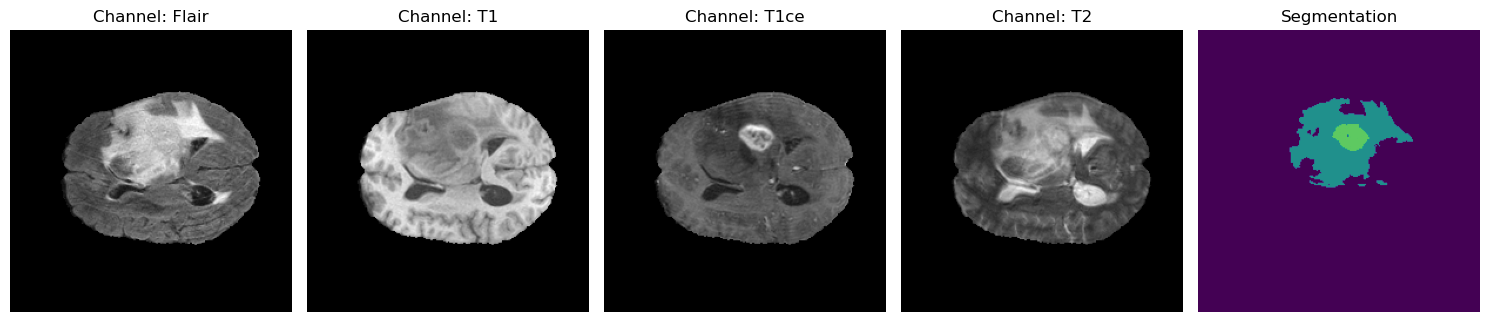

In [7]:
seg_ext = '_seg.nii.gz'
test_seg = str(seg_dir) + base + seg_ext
lbl = nib.load(str(test_seg)).get_fdata().astype(np.uint8)[:, :, 77]
channel_names = ["Flair", "T1", "T1ce", "T2"]
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))

# Display each channel
for i in range(4):
    # Taking the slice of the image at depth 77 (halfway through the depth)
    ax[i].imshow(img[:, :, 77, i], cmap='gray')
    ax[i].set_title(f"Channel: {channel_names[i]}")
    ax[i].axis("off")

ax[-1].imshow(lbl, vmin=0, vmax=4)
ax[-1].set_title("Segmentation")
ax[-1].axis('off')
plt.tight_layout()            
plt.show()

# Data Pre-processing

Each example of the BraTS20 dataset usually consists of four NIfTI files with different MRI modalities (filenames with suffixes flair, t1, t1ce, t2). Additionally, examples in the training dataset have a NIfTI with annotation (filename with suffix seg). As a first step of data pre-processing, all four modalities are stacked such that each example has shape (4, 240, 240, 155) (input tensor is in the (C, H, W, D) layout, where C-channels, H-height, W-width and D-depth). Then redundant background voxels (with voxel value zero) on the borders of each volume are cropped, as they do not provide any useful information and can be ignored by the neural network. Subsequently, for each example, the mean and the standard deviation are computed within the non-zero region for each channel separately. All volumes are normalized by first subtracting the mean and then divided by the standard deviation. The background voxels are not normalized so that their value remained at zero. To distinguish between background voxels and normalized voxels which have values close to zero, we add an input channel with one-hot encoding for foreground voxels and stacked with the input data. As a result, each example has 5 channels.

Let's start by preparing the raw training and validation datasets into stacked NIfTI files.

In [8]:
import json
import os
from glob import glob
from subprocess import call
import time

import nibabel
import numpy as np
from joblib import Parallel, delayed


def load_nifty(directory, example_id, suffix):
    return nibabel.load(os.path.join(directory, example_id + "_" + suffix + ".nii.gz"))


def load_channels(d, example_id):
    return [load_nifty(d, example_id, suffix) for suffix in ["flair", "t1", "t1ce", "t2"]]


def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)


def prepare_nifty(d):
    example_id = d.split("/")[-1]
    flair, t1, t1ce, t2 = load_channels(d, example_id)
    affine, header = flair.affine, flair.header
    vol = np.stack([get_data(flair), get_data(t1), get_data(t1ce), get_data(t2)], axis=-1)
    vol = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
    nibabel.save(vol, os.path.join(d, example_id + ".nii.gz"))

    if os.path.exists(os.path.join(d, example_id + "_seg.nii.gz")):
        seg = load_nifty(d, example_id, "seg")
        affine, header = seg.affine, seg.header
        vol = get_data(seg, "unit8")
        vol[vol == 4] = 3
        seg = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
        nibabel.save(seg, os.path.join(d, example_id + "_seg.nii.gz"))


def prepare_dirs(data, train):
    img_path, lbl_path = os.path.join(data, "images"), os.path.join(data, "labels")
    call(f"mkdir {img_path}", shell=True)
    if train:
        call(f"mkdir {lbl_path}", shell=True)
    dirs = glob(os.path.join(data, "BraTS*"))
    for d in dirs:
        if "_" in d.split("/")[-1]:
            files = glob(os.path.join(d, "*.nii.gz"))
            for f in files:
                if "flair" in f or "t1" in f or "t1ce" in f or "t2" in f:
                    continue
                if "_seg" in f:
                    call(f"mv {f} {lbl_path}", shell=True)
                else:
                    call(f"mv {f} {img_path}", shell=True)
        call(f"rm -rf {d}", shell=True)


def prepare_dataset_json(data, train):
    images, labels = glob(os.path.join(data, "images", "*")), glob(os.path.join(data, "labels", "*"))
    images = sorted([img.replace(data + "/", "") for img in images])
    labels = sorted([lbl.replace(data + "/", "") for lbl in labels])

    modality = {"0": "FLAIR", "1": "T1", "2": "T1CE", "3": "T2"}
    labels_dict = {"0": "background", "1": "edema", "2": "non-enhancing tumor", "3": "enhancing tumour"}
    if train:
        key = "training"
        data_pairs = [{"image": img, "label": lbl} for (img, lbl) in zip(images, labels)]
    else:
        key = "test"
        data_pairs = [{"image": img} for img in images]

    dataset = {
        "labels": labels_dict,
        "modality": modality,
        key: data_pairs,
    }

    with open(os.path.join(data, "dataset.json"), "w") as outfile:
        json.dump(dataset, outfile)


def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(arg) for arg in args)


def prepare_dataset(data, train):
    print(f"Preparing BraTS20 dataset from: {data}")
    start = time.time()
    run_parallel(prepare_nifty, sorted(glob(os.path.join(data, "BraTS*"))))
    prepare_dirs(data, train)
    prepare_dataset_json(data, train)
    end = time.time()
    print(f"Preparing time: {(end - start):.2f}")

prepare_dataset(str(BRATS_DATA_TRAIN_DIR), True)
prepare_dataset(str(BRATS_DATA_VAL_DIR), False)
print("Finished!")

Preparing BraTS20 dataset from: /mnt/93E8-0534/JuanCarlos/BraTS2020/MICCAI_BraTS2020_TrainingData
Preparing time: 0.01
Preparing BraTS20 dataset from: /mnt/93E8-0534/JuanCarlos/BraTS2020/MICCAI_BraTS2020_ValidationData
Preparing time: 0.00
Finished!


mkdir: cannot create directory ‘/mnt/93E8-0534/JuanCarlos/BraTS2020/MICCAI_BraTS2020_TrainingData/images’: File exists
mkdir: cannot create directory ‘/mnt/93E8-0534/JuanCarlos/BraTS2020/MICCAI_BraTS2020_TrainingData/labels’: File exists
mkdir: cannot create directory ‘/mnt/93E8-0534/JuanCarlos/BraTS2020/MICCAI_BraTS2020_ValidationData/images’: File exists


Now, lets preprocesses the datasets by cropping and normalizing the volumes. We will store the pre-processed volumes as NumPy arrays.

In [32]:
!python3 ../preprocess.py --task 11 --ohe --exec_mode training --data /mnt/93E8-0534/JuanCarlos/BraTS2020/
!python3 ../preprocess.py --task 12 --ohe --exec_mode test --data /mnt/93E8-0534/JuanCarlos/BraTS2020/
print("Finished!")

2023-06-01 11:54:51,794 - Created a temporary directory at /tmp/tmpz4drxe6o
2023-06-01 11:54:51,794 - Writing /tmp/tmpz4drxe6o/_remote_module_non_scriptable.py
Preprocessing /mnt/93E8-0534/JuanCarlos/BraTS2020/MICCAI_BraTS2020_TrainingData
2023-06-01 11:54:55,168 - Created a temporary directory at /tmp/tmpz4zd_rp8
2023-06-01 11:54:55,168 - Writing /tmp/tmpz4zd_rp8/_remote_module_non_scriptable.py
2023-06-01 11:54:55,209 - Created a temporary directory at /tmp/tmporto2g1w
2023-06-01 11:54:55,210 - Writing /tmp/tmporto2g1w/_remote_module_non_scriptable.py
2023-06-01 11:54:55,234 - Created a temporary directory at /tmp/tmp_hc8rvm3
2023-06-01 11:54:55,234 - Writing /tmp/tmp_hc8rvm3/_remote_module_non_scriptable.py
2023-06-01 11:54:55,325 - Created a temporary directory at /tmp/tmpawf9vb96
2023-06-01 11:54:55,325 - Writing /tmp/tmpawf9vb96/_remote_module_non_scriptable.py
2023-06-01 11:54:55,361 - Created a temporary directory at /tmp/tmpz3dl2mw7
2023-06-01 11:54:55,361 - Writing /tmp/tmpz3

# Data Augmentation

Data augmentation is a technique that alleviates the overfitting problem by artificially extending a dataset during the training phase. To make our method more robust, the following data augmentations are used during training phase:

1. Biased crop: From the input volume, a patch of dimensions (5, 128, 128, 128) was randomly cropped. Additionally, with probability of 0.4 the patch selected via random biased crop is guaranteed that some foreground voxels (with positive class in the ground truth) are present in the cropped region.
2. Zoom: With probability of 0.15, a zoom factor is sampled uniformly from (1.0, 1.4) and then input volume is zoomed by a sampled factor with cubic interpolation, while label with nearest neighbor interpolation.
3. Flips: With probability of 0.5, for each x, y, z axis independently, volume was flipped along that axis.
4. Gaussian Noise: With probability of 0.15, random Gaussian noise with mean zero and standard deviation sampled uniformly from (0, 0.33) is sampled for each voxel and added to the input volume.
5. Gaussian Blur: With probability of 0.15, Gaussian blurring with standard deviation of the Gaussian Kernel sampled uniformly from (0.5, 1.5) is applied to the input volume.
6. Brightness: With probability of 0.15, a random value is sampled uniformly from (0.7, 1.3) and then input volume voxels are multiplied by it.
7. Contrast: With probability of 0.15, a random value is sampled uniformly from (0.65, 1.5) and then input volume voxels are multiplied by it and clipped to its original min and max values.


# Loss function 

The BraTS leaderboard is computed based on three partially overlapping regions: whole tumor (1, 2, 4), tumor core (1, 4) and enhancing tumor (4), instead of classes present in the labels. Thus, it is beneficial to construct the loss function based on classes used for ranking calculation. Therefore, we optimize each region separately with a sum of binary Cross-Entropy with the Dice loss.

In [33]:
import torch.nn as nn
from monai.losses import DiceLoss

class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.dice = DiceLoss(sigmoid=True, batch=True)
        self.ce = nn.BCEWithLogitsLoss()

    def _loss(self, p, y):
        return self.dice(p, y) + self.ce(p, y.float())

    def forward(self, p, y):
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        p_wt, p_tc, p_et = p[:, 0].unsqueeze(1), p[:, 1].unsqueeze(1), p[:, 2].unsqueeze(1)
        l_wt, l_tc, l_et = self._loss(p_wt, y_wt), self._loss(p_tc, y_tc), self._loss(p_et, y_et)
        return l_wt + l_tc + l_et

# Model

We have made some modifications to the U-Net architecture for the BraTS challenge with respect to the original nnU-Net template. In particular, the U-Net template in the nnU-Net has the encoder depth of 6, and the convolution channels at each encoder level are: 32, 64, 128, 256, 320, 320. Based on the experiments we run, increasing the depth of the encoder to 7, modifying the number of channels to: 64, 96, 128, 192, 256, 384, 512, and using deep supervision improves the final score.

For deep supervision, we used two additional output heads at the decoder levels with feature map sizes (64, 64, 64) and (32, 32, 32). To match the shape of the additional predictions with the label shape of (128, 128, 128) we downsampled the label using the nearest neighbor interpolation to the (64, 64, 64) and (32, 32, 32) shapes, so that loss can be computed for additional outputs.

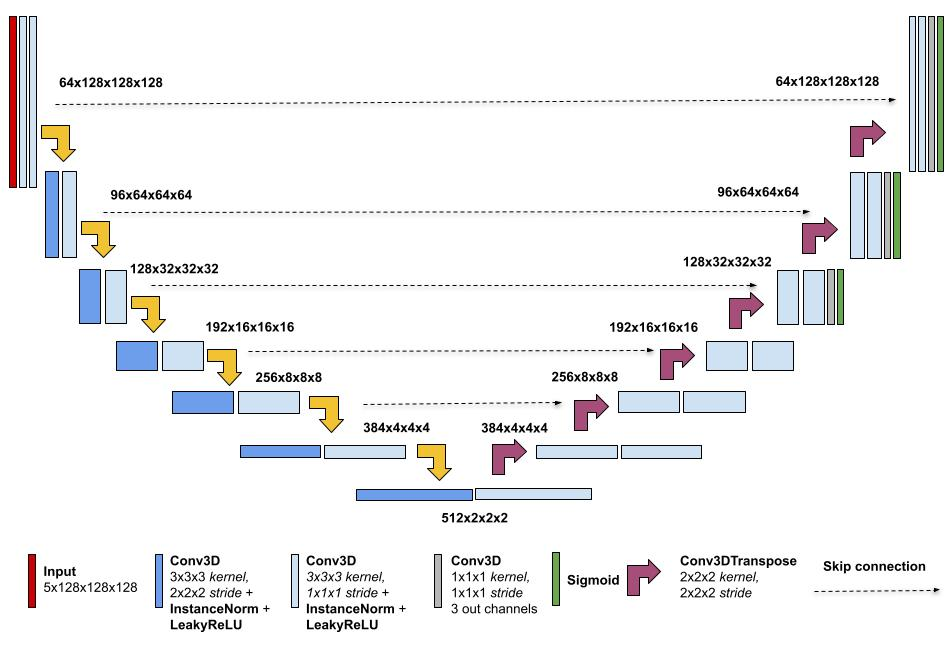

In [34]:
from IPython.display import Image
Image(filename="../images/unet-brats.jpg")

# Training

Follow this link and adjust the notebook to the nnUnet repo to not run into trouble. https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Segmentation/nnUNet/notebooks/BraTS21.ipynb